## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path
results_dir = arl_path('test_results')

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'


from matplotlib import pyplot as plt

import numpy

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from data_models.polarisation import PolarisationFrame

from wrappers.serial.image.iterators import image_raster_iter

from wrappers.serial.visibility.base import create_visibility
from wrappers.serial.visibility.operations import sum_visibility
from wrappers.serial.visibility.iterators import vis_timeslices, vis_wslices
from wrappers.serial.simulation.testing_support import create_named_configuration
from wrappers.serial.skycomponent.operations import create_skycomponent, find_skycomponents, \
    find_nearest_skycomponent, insert_skycomponent
from wrappers.serial.image.operations import show_image, export_image_to_fits, qa_image, smooth_image
from wrappers.serial.simulation.testing_support import create_named_configuration
from wrappers.serial.imaging.base import advise_wide_field, create_image_from_visibility, \
    predict_skycomponent_visibility

from wrappers.arlexecute.griddata.kernels import create_awterm_convolutionfunction
from wrappers.arlexecute.griddata.convolution_functions import apply_bounding_box_convolutionfunction

# Use workflows for imaging
from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from workflows.shared.imaging.imaging_shared import imaging_contexts
from workflows.arlexecute.imaging.imaging_arlexecute import predict_list_arlexecute_workflow, \
    invert_list_arlexecute_workflow
import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


backend module://ipykernel.pylab.backend_inline version unknown


Construct the SKA1-LOW core configuration

In [2]:
arlexecute.set_client(use_dask=True)

Using selector: KqueueSelector
Using selector: KqueueSelector


In [3]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 95865 rows, 0.010 GB


In [5]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wide_field: Frequency sampling for full image = 29212.6 (Hz)
advice_wide_field: Frequency sampling for primary beam = 1051653.8 (Hz)
advice_wide_field: Number of planes in w st

Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 32
Component at (240.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (4.74378292, -51.0209895)>
insert_skycomponent: Using insert method Nearest
Component at (208.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (7.66144755, -51.22149637)>
insert_skycomponent: Using insert method Nearest
Component at (176.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (10.5917361, -51.35530369)>
insert_skycomponent: Using insert method Nearest
Component

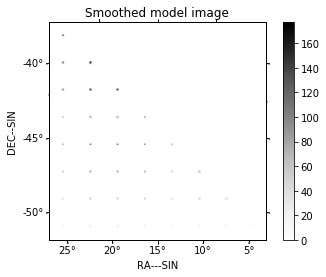

In [6]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1, 
                                     polarisation_frame=PolarisationFrame('stokesI'))
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            insert_skycomponent(model, comp)

predict_skycomponent_visibility(vt, original_comps)

        
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


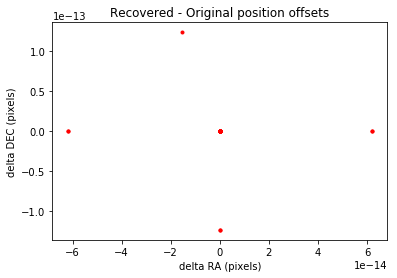

In [7]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp, sep = find_nearest_skycomponent(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Make the convolution function

create_w_term_image: For w = -440.0, field of view = 0.256000, Fresnel number = 7.21
create_w_term_image: For w = -432.0, field of view = 0.256000, Fresnel number = 7.08
create_w_term_image: For w = -424.0, field of view = 0.256000, Fresnel number = 6.95
create_w_term_image: For w = -416.0, field of view = 0.256000, Fresnel number = 6.82
create_w_term_image: For w = -408.0, field of view = 0.256000, Fresnel number = 6.68
create_w_term_image: For w = -400.0, field of view = 0.256000, Fresnel number = 6.55
create_w_term_image: For w = -392.0, field of view = 0.256000, Fresnel number = 6.42
create_w_term_image: For w = -384.0, field of view = 0.256000, Fresnel number = 6.29
create_w_term_image: For w = -376.0, field of view = 0.256000, Fresnel number = 6.16
create_w_term_image: For w = -368.0, field of view = 0.256000, Fresnel number = 6.03
create_w_term_image: For w = -360.0, field of view = 0.256000, Fresnel number = 5.90
create_w_term_image: For w = -352.0, field of view = 0.256000, Fr

create_w_term_image: For w = 344.0, field of view = 0.256000, Fresnel number = 5.64
create_w_term_image: For w = 352.0, field of view = 0.256000, Fresnel number = 5.77
create_w_term_image: For w = 360.0, field of view = 0.256000, Fresnel number = 5.90
create_w_term_image: For w = 368.0, field of view = 0.256000, Fresnel number = 6.03
create_w_term_image: For w = 376.0, field of view = 0.256000, Fresnel number = 6.16
create_w_term_image: For w = 384.0, field of view = 0.256000, Fresnel number = 6.29
create_w_term_image: For w = 392.0, field of view = 0.256000, Fresnel number = 6.42
create_w_term_image: For w = 400.0, field of view = 0.256000, Fresnel number = 6.55
create_w_term_image: For w = 408.0, field of view = 0.256000, Fresnel number = 6.68
create_w_term_image: For w = 416.0, field of view = 0.256000, Fresnel number = 6.82
create_w_term_image: For w = 424.0, field of view = 0.256000, Fresnel number = 6.95
create_w_term_image: For w = 432.0, field of view = 0.256000, Fresnel number

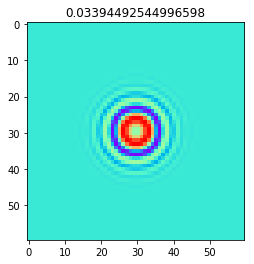

(1, 1, 110, 8, 8, 34, 34)


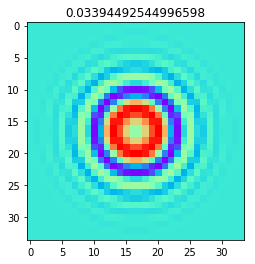

In [8]:
wstep = 8.0
nw = int(1.1 * 800/wstep)
    
gcfcf = create_awterm_convolutionfunction(model, nw=110, wstep=8, oversampling=8, 
                                                    support=60,
                                                    use_aaf=True)
    
cf=gcfcf[1]
print(cf.data.shape)
plt.clf()
plt.imshow(numpy.real(cf.data[0,0,0,0,0,:,:]))
plt.title(str(numpy.max(numpy.abs(cf.data[0,0,0,0,0,:,:]))))
plt.show()
    
cf_clipped = apply_bounding_box_convolutionfunction(cf, fractional_level=1e-3)
print(cf_clipped.data.shape)
gcfcf_clipped=(gcfcf[0], cf_clipped)
    
plt.clf()
plt.imshow(numpy.real(cf_clipped.data[0,0,0,0,0,:,:]))
plt.title(str(numpy.max(numpy.abs(cf_clipped.data[0,0,0,0,0,:,:]))))
plt.show()


Predict the visibility using the different approaches.

In [9]:
contexts = imaging_contexts().keys()
print(contexts)

dict_keys(['2d', 'facets', 'facets_timeslice', 'facets_wstack', 'timeslice', 'wstack'])


In [10]:
print(gcfcf_clipped[1])

Convolution function:
	Shape: (1, 1, 110, 8, 8, 34, 34)
	Grid WCS: WCS Keywords

Number of WCS axes: 7
CTYPE : 'UU'  'VV'  'DUU'  'DVV'  'WW'  'STOKES'  'FREQ'  
CRVAL : 0.0  0.0  0.0  0.0  0.0  1.0  100000000.0  
CRPIX : 18.0  18.0  5.0  5.0  56.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4 PC1_5 PC1_6 PC1_7  : 1.0  0.0  0.0  0.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4 PC2_5 PC2_6 PC2_7  : 0.0  1.0  0.0  0.0  0.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4 PC3_5 PC3_6 PC3_7  : 0.0  0.0  1.0  0.0  0.0  0.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4 PC4_5 PC4_6 PC4_7  : 0.0  0.0  0.0  1.0  0.0  0.0  0.0  
PC5_1 PC5_2 PC5_3 PC5_4 PC5_5 PC5_6 PC5_7  : 0.0  0.0  0.0  0.0  1.0  0.0  0.0  
PC6_1 PC6_2 PC6_3 PC6_4 PC6_5 PC6_6 PC6_7  : 0.0  0.0  0.0  0.0  0.0  1.0  0.0  
PC7_1 PC7_2 PC7_3 PC7_4 PC7_5 PC7_6 PC7_7  : 0.0  0.0  0.0  0.0  0.0  0.0  1.0  
CDELT : -3.90625  3.90625  -0.48828125  0.48828125  8.0  1.0  999999.99999  
NAXIS : 0  0
	Projection WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN

Processing context 2d
create_visibility: 95865 rows, 0.010 GB


/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/worker.py:901: UserWarning: Large object of size 10.75 MB detected in task graph: 
  (['predict_ignore_none-efd098a6ec201113a9f60584842 ... t 0x1159cd048>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


arlexecute.compute: Execution using Dask took 2.968 seconds
arlexecute.compute: Execution using Dask took 2.968 seconds


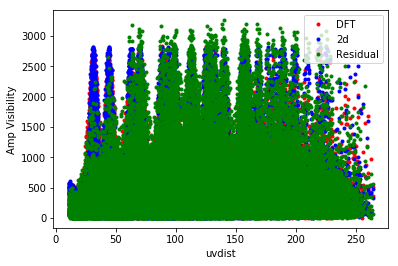

Processing context timeslice
create_visibility: 95865 rows, 0.010 GB
arlexecute.compute: Execution using Dask took 4.040 seconds
arlexecute.compute: Execution using Dask took 4.040 seconds


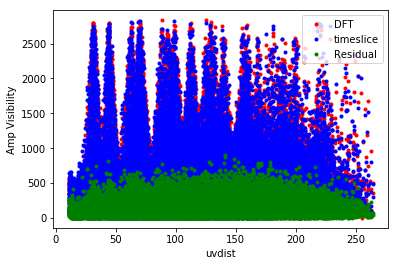

Processing context wstack
create_visibility: 95865 rows, 0.010 GB
arlexecute.compute: Execution using Dask took 2.102 seconds
arlexecute.compute: Execution using Dask took 2.102 seconds


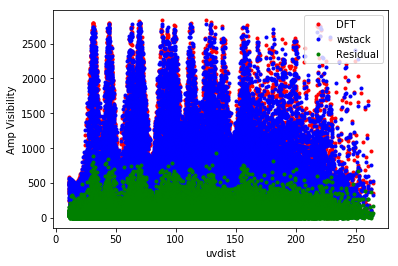

Processing context wprojection
create_visibility: 95865 rows, 0.010 GB
arlexecute.compute: Execution using Dask took 3.551 seconds
arlexecute.compute: Execution using Dask took 3.551 seconds


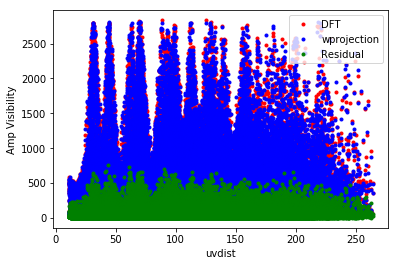

In [11]:
contexts = ['2d', 'facets', 'timeslice', 'wstack', 'wprojection']

for context in contexts:
    
    print('Processing context %s' % context)
   
    vtpredict_list =[create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
        weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))]
    model_list = [model]

 
    if context == 'wprojection':       
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context='2d', gcfcf=[gcfcf_clipped])
    
    elif context == 'facets':
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context, facets=8)
        
    elif context == 'timeslice':
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context, vis_slices=vis_timeslices(
            vtpredict, 'auto'))

    elif context == 'wstack':
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context, vis_slices=31)

    else:
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context)
        
    vtpredict_list = arlexecute.compute(future, sync=True)
        
    vtpredict = vtpredict_list[0]

    uvdist = numpy.sqrt(vt.data['uvw'][:, 0] ** 2 + vt.data['uvw'][:, 1] ** 2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")
    
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=context)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:] - vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()


Make the image using the different approaches. We will evaluate the results using a number of plots:

- The error in fitted versus the radius. The ideal result is a straightline fitted: flux = DFT flux
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.

The sampling in w is set to provide 2% decorrelation at the half power point of the primary beam.


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context 2d
arlexecute.compute: Execution using Dask took 2.132 seconds
arlexecute.compute: Execution using Dask took 2.132 seconds


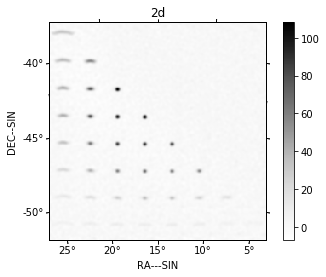

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor 2d
	Data:
		shape: '(1, 1, 256, 256)'
		max: '108.21300548606462'
		min: '-6.956122299795651'
		rms: '4.883120122463161'
		sum: '2049.6941259580435'
		medianabs: '1.167421628311499'
		median: '-0.6031791026339453'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


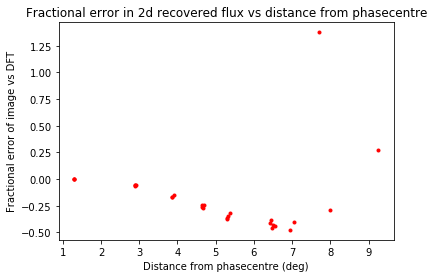

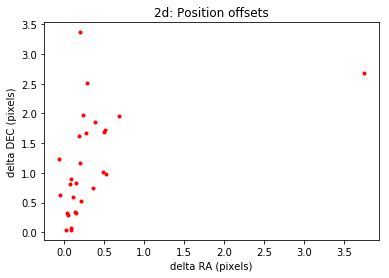

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context facets
arlexecute.compute: Execution using Dask took 32.310 seconds
arlexecute.compute: Execution using Dask took 32.310 seconds


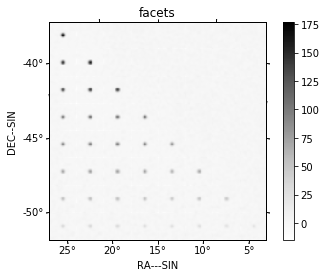

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor facets
	Data:
		shape: '(1, 1, 256, 256)'
		max: '176.57243431251476'
		min: '-14.852549416354838'
		rms: '6.629684786545091'
		sum: '-1250.7635026858604'
		medianabs: '1.1827474534240456'
		median: '-0.6884764168208577'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


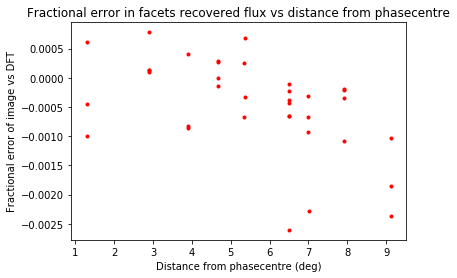

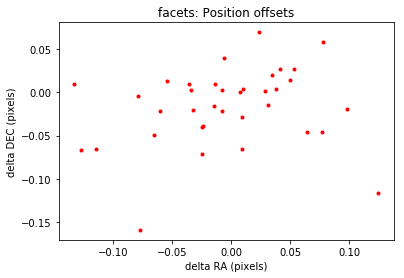

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context timeslice
arlexecute.compute: Execution using Dask took 2.009 seconds
arlexecute.compute: Execution using Dask took 2.009 seconds


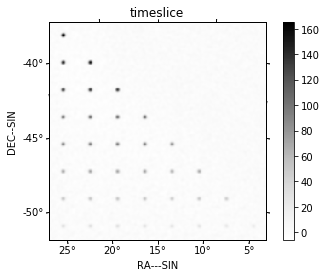

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor timeslice
	Data:
		shape: '(1, 1, 256, 256)'
		max: '164.99104941146877'
		min: '-5.866856763110356'
		rms: '6.439728312100784'
		sum: '3434.4593476226555'
		medianabs: '1.1148946036171283'
		median: '-0.6292639829732477'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


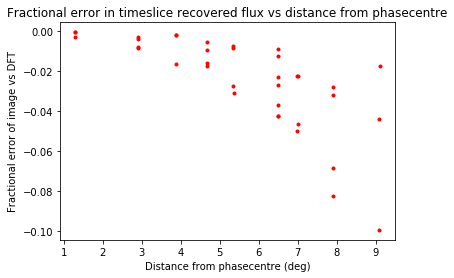

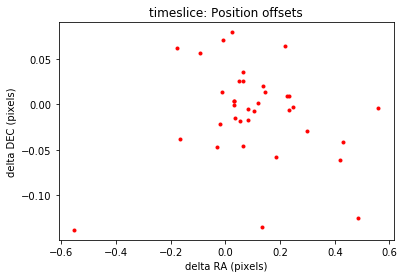

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context wstack
arlexecute.compute: Execution using Dask took 1.746 seconds
arlexecute.compute: Execution using Dask took 1.746 seconds


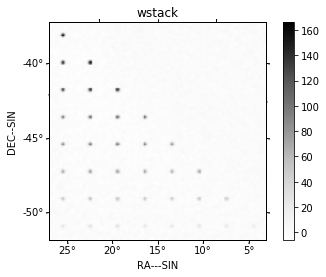

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor wstack
	Data:
		shape: '(1, 1, 256, 256)'
		max: '166.13305564578872'
		min: '-6.020498185473124'
		rms: '6.429171276425278'
		sum: '1801.7911167571763'
		medianabs: '1.1542821936263237'
		median: '-0.6684677242653245'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


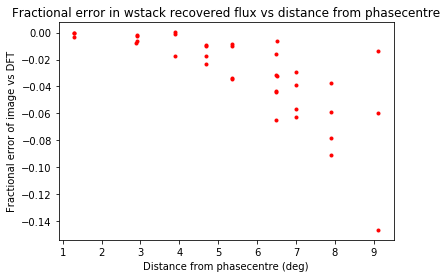

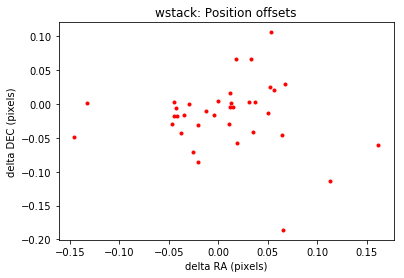

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context wprojection
arlexecute.compute: Execution using Dask took 3.885 seconds
arlexecute.compute: Execution using Dask took 3.885 seconds


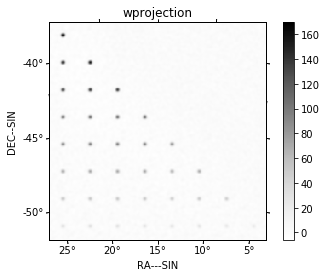

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor wprojection
	Data:
		shape: '(1, 1, 256, 256)'
		max: '169.67212193743603'
		min: '-5.920502224542853'
		rms: '6.4648570492593045'
		sum: '2829.9939075137295'
		medianabs: '1.1264006866782483'
		median: '-0.6524193470693205'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


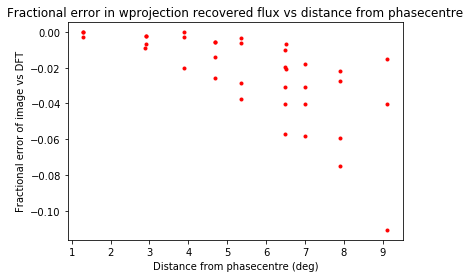

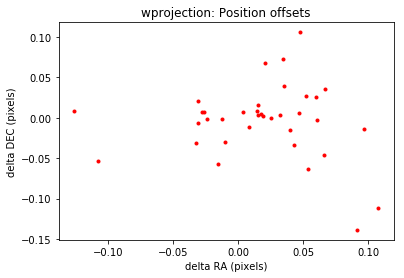

In [12]:
contexts = ['2d', 'facets', 'timeslice', 'wstack', 'wprojection']

for context in contexts:

    targetimage_list = [create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1,
                                               polarisation_frame=PolarisationFrame('stokesI'))]
    
    vt_list = [vt]


    print('Processing context %s' % context)
    if context == 'wprojection':
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context='2d', gcfcf=[gcfcf_clipped])
    
    elif context == 'facets':
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context, facets=8)
        
    elif context == 'timeslice':
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context, vis_slices=vis_timeslices(vt, 'auto'))

    elif context == 'wstack':
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context, vis_slices=31)

    else:
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context)
        
    result = arlexecute.compute(future, sync=True)
    targetimage = result[0][0]

    show_image(targetimage)
    plt.title(context)
    plt.show()

    print("Dirty Image %s" % qa_image(targetimage, context="imaging-fits notebook, using processor %s" % context))

    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' % (results_dir, context))
    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)

    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        dft_flux = sum_visibility(vt, comp.direction)[0]
        err = (comp.flux[0, 0] - dft_flux) / dft_flux
        plt.plot(distance, err, '.', color='r')
    plt.ylabel('Fractional error of image vs DFT')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.title(
        "Fractional error in %s recovered flux vs distance from phasecentre" %
        context)
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp, sep = find_nearest_skycomponent(comps[i].direction, original_comps)
            plt.plot(
                (comps[i].direction.ra.value - ocomp.direction.ra.value) /
                targetimage.wcs.wcs.cdelt[0],
                (comps[i].direction.dec.value - ocomp.direction.dec.value) /
                targetimage.wcs.wcs.cdelt[1],
                '.',
                color='r')

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % context)
        plt.show()